In [1]:
from datetime import datetime as dt
import csv, os, glob
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from scipy import interp

import tensorflow.keras as k
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# load tensorboard
%load_ext tensorboard

2021-08-13 09:56:50.251446: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def draw_CM(label, predicted):
    cm = confusion_matrix(label, predicted)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # true : false rate
    true = 0
    false = 0
    for i, j in enumerate(label):
        if j != predicted[i]:
            false += 1
        else: true += 1

    classification_report = metrics.classification_report(label, predicted)
    multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

    return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10, 'classification_report: ', '\n', classification_report), print('='*10, 'multilabel_to_binary_matrics by class_num: ','\n','[[TN / FP] [FN / TP]]','\n', multilabel_to_binary_matrics)


def draw_ROC_AUC(x, y, category_names):
    n_classes = len(category_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], x[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), x.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
            color='deeppink', linestyle=':', linewidth=1)

    plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=1)

    colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC')
    plt.legend(loc="lower right")

    return plt.show()

In [3]:
# dataframe = []
# # cnt = 0
# path = '/home/z/PycharmProjects/test/label/'
# for i in glob.glob(path + '*.csv'):
#     df = pd.read_csv(i)
#     df = df[['device_field03', 'illuminance_onoff', 'device_data_reg_dtm']]
#     dataframe.append(df)
#     # cnt += 1
# df = pd.concat(dataframe)

## 1. load dataset

In [4]:
# path
path = "/home/z/data/label/labeling_NW0461.csv"
df = pd.read_csv(path)
df = df[['device_field03', 'illuminance_onoff', 'device_data_reg_dtm']]
light_data = df['device_field03']
label_data = df['illuminance_onoff']
time_data = df['device_data_reg_dtm']

start = 230
end = 245

print(light_data.shape, label_data.shape)
print(df)

(48268,) (48268,)
       device_field03  illuminance_onoff  device_data_reg_dtm
0                 0.0                  9  2020-07-01 00:08:37
1                 0.0                  9  2020-07-01 00:18:37
2                 0.0                  9  2020-07-01 00:28:36
3                 0.0                  9  2020-07-01 00:38:39
4                 0.0                  9  2020-07-01 00:48:39
...               ...                ...                  ...
48263            50.0                  9  2021-06-30 21:01:01
48264            50.0                  9  2021-06-30 21:11:00
48265            50.0                  9  2021-06-30 21:21:00
48266            51.0                  9  2021-06-30 21:31:00
48267            51.0                  9  2021-06-30 21:41:01

[48268 rows x 3 columns]


## 2. preprocess data

In [5]:
# 9 to 0
classes = ["idle", "on", "off"]
class_list = list(range(len(classes)))
prev = 0
idle = 0
on = 1
off = 2
for row, label in label_data.iteritems():
    if prev == 0 and label == 1:
        df.at[row, 'illuminance_onoff'] = on
    elif prev == 1 and label == 0:
        df.at[row, 'illuminance_onoff'] = off
    else:
        df.at[row, 'illuminance_onoff'] = idle
    prev = label

In [6]:
# # plot
# fig = px.line(df, x='device_data_reg_dtm', y=['device_field03', 'illuminance_onoff'])
# fig.update_xaxes(rangeslider_visible=True)
# fig.show(renderer='browser')

In [7]:
# Nomalize
print(light_data[100:110])
mx = light_data.max()
norm_data = light_data / mx
# print(norm_data.shape)
print(norm_data[100:110])

100    10.0
101     9.0
102    13.0
103    10.0
104     6.0
105     7.0
106     9.0
107     3.0
108     5.0
109     3.0
Name: device_field03, dtype: float64
100    0.158730
101    0.142857
102    0.206349
103    0.158730
104    0.095238
105    0.111111
106    0.142857
107    0.047619
108    0.079365
109    0.047619
Name: device_field03, dtype: float64


In [8]:
# Split
split_index = int(len(light_data)*0.9)
train_data, test_data = norm_data[:split_index], norm_data[split_index:]
train_label, test_label = label_data[:split_index], label_data[split_index:]

test_data.reset_index(drop=True, inplace=True)
test_label.reset_index(drop=True, inplace=True)

In [9]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

print(train_data[100:105])
print(train_label[100:105])
print(test_data[100:105])
print(test_label[100:105])

(43441,) (43441,)
(4827,) (4827,)
100    0.158730
101    0.142857
102    0.206349
103    0.158730
104    0.095238
Name: device_field03, dtype: float64
100    0
101    0
102    0
103    0
104    0
Name: illuminance_onoff, dtype: int64
100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
Name: device_field03, dtype: float64
100    0
101    0
102    0
103    0
104    0
Name: illuminance_onoff, dtype: int64


## 3. make sequence

In [10]:
def to_sequences(seq_size, t1, t2):
    x = []
    y = []
    for i in range(len(t1)-seq_size):
        ta1 = t1[i:(i+seq_size)]
        ta2 = t2[i-1+seq_size]
        # ta1 = [[x] for x in ta1]
        x.append(ta1)
        y.append(ta2)
        
    # return x, y
    return np.array(x), np.array(y)


window = 3
x_train, y_train = to_sequences(window, train_data, train_label)
x_test, y_test = to_sequences(window, test_data, test_label)

In [11]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

43438 43438
4824 4824


In [12]:
# remove unbalance labels
def remove_zero_data(t1, t2):
    x = []
    y = []
    for i in range(len(t1)):
        if sum(t1[i]) > 0.1:
            x.append(t1[i])
            y.append(t2[i])
    
    return np.array(x), np.array(y)

x_train, y_train = remove_zero_data(x_train, y_train)
x_test, y_test = remove_zero_data(x_test, y_test)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train[100:105])
print(y_train[100:105])
print(x_test[100:105])
print(y_test[100:105])

(17133, 3) (17133,)
(2969, 3) (2969,)
[[0.26984127 0.25396825 0.25396825]
 [0.25396825 0.25396825 0.26984127]
 [0.25396825 0.26984127 0.22222222]
 [0.26984127 0.22222222 0.22222222]
 [0.22222222 0.22222222 0.22222222]]
[0 0 0 0 0]
[[0.06349206 0.04761905 0.04761905]
 [0.04761905 0.04761905 0.04761905]
 [0.04761905 0.04761905 0.06349206]
 [0.04761905 0.06349206 0.06349206]
 [0.06349206 0.06349206 0.04761905]]
[0 0 0 0 0]


In [14]:
# # one-hot encoding
# def label_maker(target):
#     result = []
#     for i in target:
#         cal = [0,0,0]
#         cal[i] = 1
#         result.append(cal)

#     return np.array(result)

# y_train = label_maker(y_train)
# y_test = label_maker(y_test)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(x_train[:2])
# print(y_train[:2])
# print(x_test[:2])
# print(y_test[:2])

## 4. make & train model

In [15]:
# def build_model(hp):
#   model = k.Sequential()
#   model.add(k.layers.Dense(hp.Choice('units', [8, 16, 32]), activation='relu'))
#   model.add(k.layers.Dense(1, activation='sigmoid'))
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#   return model

# tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10)
# tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
# best_model = tuner.get_best_models()[0]

In [16]:
# model
input = k.Input(shape=(window, ))
# input = k.Input(shape=(1, timesteps))

# x = k.layers.LSTM(128, activation='tanh', recurrent_activation='sigmoid', dropout=0, recurrent_dropout=0, unroll=False, use_bias=True)(input)
x = k.layers.Dense(16, activation="relu")(input)
# x = k.layers.Dense(64, activation="relu")(x)
# x = k.layers.Dense(32, activation="relu")(x)
# x = k.layers.Dense(16, activation="relu")(x)
x = k.layers.Dense(8, activation="relu")(x)

output = k.layers.Dense(3, activation="softmax")(x)

model = k.Model(input, output)

2021-08-13 09:56:54.444493: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-13 09:56:54.482608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-13 09:56:54.482977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3070 Ti computeCapability: 8.6
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.76GiB deviceMemoryBandwidth: 566.30GiB/s
2021-08-13 09:56:54.483032: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-13 09:56:54.485515: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-13 09:56:54.485630: I tensorflow/stream_executor/platform

2021-08-13 09:56:55.009350: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-13 09:56:55.009371: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-13 09:56:55.009396: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-08-13 09:56:55.011042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2021-08-13 09:56:55.130034: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-13 09:56:55.131883: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-08-13 09:56:55.176884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-13 09:56:55.196319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz
2021-08-13 09:56:55.404726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 154/1285 [==>...........................] - ETA: 1s - loss: 0.6691 - accuracy: 0.9329

2021-08-13 09:56:55.849275: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-13 09:56:55.849323: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1285/1285 [==============================] - 2s 1ms/step - loss: 0.1858 - accuracy: 0.9658 - val_loss: 0.0607 - val_accuracy: 0.9842
Epoch 2/1000
1285/1285 [==============================] - 2s 1ms/step - loss: 0.0323 - accuracy: 0.9934 - val_loss: 0.0522 - val_accuracy: 0.9860
Epoch 3/1000
1285/1285 [==============================] - 1s 1ms/step - loss: 0.0232 - accuracy: 0.9947 - val_loss: 0.0544 - val_accuracy: 0.9860
Epoch 4/1000
1285/1285 [==============================] - 1s 1ms/step - loss: 0.0218 - accuracy: 0.9952 - val_loss: 0.0554 - val_accuracy: 0.9866
Epoch 5/1000
1285/1285 [==============================] - 2s 1ms/step - loss: 0.0210 - accuracy: 0.9949 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 6/1000
1285/1285 [==============================] - 2s 1ms/step - loss: 0.0209 - accuracy: 0.9951 - val_loss: 0.0564 - val_accuracy: 0.9877
Epoch 7/1000
1285/1285 [==============================] - 2s 1ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0579 - val_accuracy

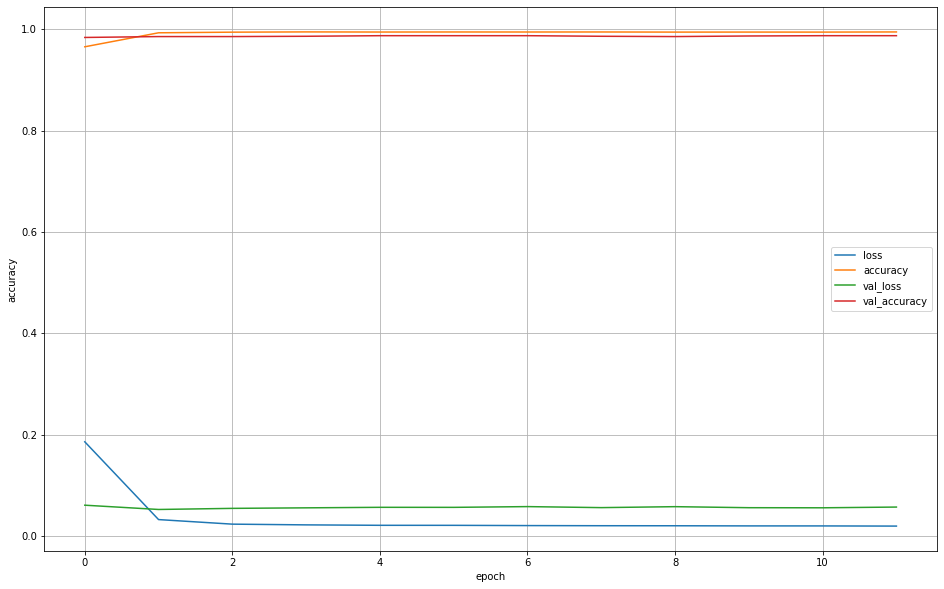

In [17]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit
log_path = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="val_loss", patience=10, mode="auto", verbose=2)

history = model.fit(x_train, y_train, validation_split=0.1, batch_size=12, epochs=1000, verbose=1, callbacks=[es]) # callbacks=[es, tensorboard_callback])
print(history)

# plot
pd.DataFrame(history.history).plot(figsize=(16,10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()

In [18]:
# # save model
# file_name =  "model/light_detector_" + dt.now().strftime("%Y%m%d-%H%M%S")
# model_format = ".h5"
# model_name = file_name + model_format
# model.save(model_name)

## 5. evaluate & predict model

In [19]:
# evauate
# model_name = "/home/z/PycharmProjects/light_onoff_detector/model/light_detector_20210811-135021.h5"
# model = k.models.load_model(model_name)
loss, acc = model.evaluate(x_test, y_test, verbose=1)
# print(f'test_loss: {loss} test_accuracy: {acc}')

93/93 [==============================] - 0s 727us/step - loss: 0.0383 - accuracy: 0.9916


In [28]:
predict = model.predict(x_test)
predicted = np.argmax(predict, axis=1)
# y1 = np.argmax(y_test, axis=1) # for one-hot encoding
# draw_CM(y1, predicted)

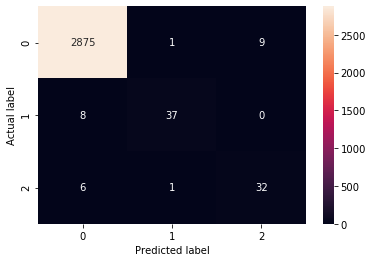

true rate:  2944
false rate:  25

========== classification_report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2885
           1       0.95      0.82      0.88        45
           2       0.78      0.82      0.80        39

    accuracy                           0.99      2969
   macro avg       0.91      0.88      0.89      2969
weighted avg       0.99      0.99      0.99      2969

========== multilabel_to_binary_matrics by class_num:  
 [[TN / FP] [FN / TP]] 
 [[[  70   14]
  [  10 2875]]

 [[2922    2]
  [   8   37]]

 [[2921    9]
  [   7   32]]]


(None, None, None, None, None, None)

In [29]:
# CM
draw_CM(y_test, predicted)

In [31]:
# ROC, AUC
draw_ROC_AUC(predicted, y_test, classes)

IndexError: invalid index to scalar variable.

/home/z/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/z/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive sa

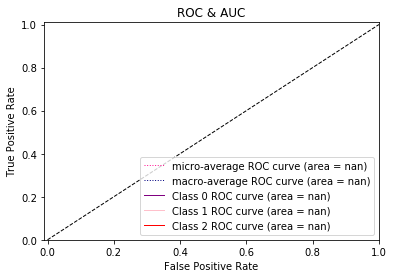

In [25]:
# ROC, AUC
x = label_binarize(predicted, classes=classes)
y = label_binarize(y_test, classes=classes)

draw_ROC_AUC(x, y, classes)

In [ ]:
# # launch tensorboard @ localhost:6006
# %tensorboard --logdir logs/ --host localhost --port 6006

In [ ]:
# df.to_csv("data.csv", index=False)